In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pickle
%matplotlib inline

# Data Preparation 

#### Reading data and preparing the test, train and validation sets

In [1]:
# Hyper parameters 
input_size = 784
output_size = 10

In [21]:
class NN:  
        
    def __init__(self, hidden_dims=(512,512), mode='train', datapath=None, model_path=None): 
        self.mode = mode
        data = np.load(datapath)
        if (mode == 'train'):
            self.X_train = data['x_train'][:48000].reshape(48000, 784)
            self.y_train = data["y_train"][:48000]
            self.X_valid = data['x_train'][48000:].reshape(12000, 784)
            self.y_valid = data["y_train"][48000:]            
            self.hidden_dims=(512,512)
        elif(mode == 'test'):
            self.X_test = data['x_test'].reshape(10000, 784)
            self.y_test = data['y_test']
            with open(model_path,'rb') as f:
                 self.Params = pickle.load(f)
                    
    def initialize_weights(self, init_method):
        
        if (init_method == "normal"):                    
            W1 = np.random.normal(0, 1, (self.hidden_dims[0], input_size))
            b1 = np.zeros(self.hidden_dims[0])
            W2 = np.random.normal(0, 1, (self.hidden_dims[1], self.hidden_dims[0]))
            b2 = np.zeros(self.hidden_dims[1])
            W3 = np.random.normal(0, 1, (output_size, self.hidden_dims[1]))
            b3 = np.zeros(output_size)
            
        elif(init_method == "Glorot"):
            d0_Glorot = np.sqrt(6.0 / (input_size + self.hidden_dims[0]))
            W1 = np.random.uniform(-d0_Glorot, d0_Glorot, size=(self.hidden_dims[0], input_size))
            b1 = np.zeros(self.hidden_dims[0])
            d1_Glorot = np.sqrt(6.0 / (self.hidden_dims[1] + self.hidden_dims[0]))
            W2 = np.random.uniform(-d1_Glorot, d1_Glorot, size=(self.hidden_dims[1], self.hidden_dims[0]))
            b2 = np.zeros(self.hidden_dims[1])
            d2_Glorot = np.sqrt(6.0 / (output_size + self.hidden_dims[1]))
            W3 = np.random.uniform(-d2_Glorot, d2_Glorot, size=(output_size, self.hidden_dims[1]))
            b3 = np.zeros(output_size)
        
        elif(init_method == "zeros"):
            W1 = np.zeros((self.hidden_dims[0], input_size))
            b1 = np.zeros(self.hidden_dims[0])
            W2 = np.zeros((self.hidden_dims[1], self.hidden_dims[0]))
            b2 = np.zeros(self.hidden_dims[1])
            W3 = np.zeros((output_size, self.hidden_dims[1]))
            b3 = np.zeros(output_size)       
        
        self.Params = {'W1':W1, 'b1':b1,
                       'W2':W2, 'b2':b2,
                       'W3':W3, 'b3':b3}
    
    def forward(self, x):            
        N = x.shape[0]
        h1, h1_cache = self.fc_forward(x, self.Params['W1'], self.Params['b1'])
        a1, a1_cache = self.relu_forward(h1)
        h2, h2_cache = self.fc_forward(a1, self.Params['W2'], self.Params['b2'])
        a2, a2_cache = self.relu_forward(h2)
        scores, scores_cache = self.fc_forward(a2, self.Params['W3'], self.Params['b3'])
        preds = np.argmax(scores, axis=1)
        self.cache = (N, h1_cache, a1_cache, h2_cache, a2_cache, scores_cache)
        return preds, scores
    
    def backward(self, dsoftmax):        
        (N, h1_cache, a1_cache, h2_cache, a2_cache, scores_cache) = self.cache
        da2, dW3, db3= self.fc_backward(dsoftmax, scores_cache)
        dh2 = self.relu_backward(da2, a2_cache)
        da1, dW2, db2= self.fc_backward(dh2, h2_cache)
        dh1 = self.relu_backward(da1, a1_cache)
        
        _, dW1, db1= self.fc_backward(dh1, h1_cache)
        
        dW3 /= N
        dW2 /= N
        dW1 /= N
        db3 /= N
        db2 /= N
        db1 /= N
        
        dW3 += weight_decay * self.Params['W3']
        dW2 += weight_decay * self.Params['W2']
        dW1 += weight_decay * self.Params['W1']
        
        grads = {'W1':dW1, 'b1':db1,
                 'W2':dW2, 'b2':db2,
                 'W3':dW3, 'b3':db3}
        return grads
        
    
    def fc_forward(self, x, w, b):        
        out = np.dot(x, w.T) + b
        cache = (x, w, b, out)
        return out, cache
    
    def fc_backward(self, dupstream, cache):        
        (x, w, b, out) = cache
        dx = np.dot(dupstream, w)
        dw = np.dot(dupstream.T, x)
        db = dupstream.sum(axis=0)
        return dx, dw, db
    
    ### Activation function
    def relu_forward(self, x):        
        return np.maximum(0, x), x
    
    def relu_backward(self, dupstream, cache):        
        return ((cache > 0) * dupstream)  
    
        
    def update(self, grads):
        for param, grad in grads.items():
                self.Params[param] -= learning_rate * grad
    
    ### Calculate Softmax and loss function
    def softmax_loss(self, scores, y):      
        shifted_logits = scores - np.max(scores, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(Z)
        probs = np.exp(log_probs)   
        N = scores.shape[0]
        loss = -np.sum(log_probs[np.arange(N), y]) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N
        return loss, dx  
    
    def train(self, mb_size=100):        
        for i in range(self.X_train.shape[0] // mb_size):
            xi = self.X_train[i*mb_size:(i+1)*mb_size]
            yi = self.y_train[i*mb_size:(i+1)*mb_size]
            preds, scores = self.forward(xi)
            softmax_loss, dsoftmax = self.softmax_loss(scores, yi)
            grads = self.backward(dsoftmax)
            self.update(grads)
        return softmax_loss
    
    def test(self, x, y):
        preds, scores = self.forward(x)
        softmax_loss, dsoftmax = self.softmax_loss(scores, y)
        return softmax_loss, preds

In [22]:
def run_train(init_method, num_epochs = 10):
    nn = NN(datapath = './mnist.npz', mode = 'train')
    nn.initialize_weights(init_method = init_method)
    train_accuracies, train_losses = [], []
    valid_accuracies, valid_losses = [], []
    test_accuracies, test_losses = [], []

    for e in range(num_epochs):
        loss = nn.train(mb_size=100)

        #loss_train, pred_train = nn.test(nn.X_test, nn.y_test)
        loss_valid, pred_valid = nn.test(nn.X_valid, nn.y_valid)
        valid_losses.append(loss_valid)
        valid_accuracies.append((pred_valid == nn.y_valid).mean())
        #train_losses.append(loss_train)
        #train_accuracies.append((pred_train == nn.y_train).mean())
    
    plt.figure(figsize=(12, 4))
    axis = plt.subplot(1, 2, 1)
    #axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
    axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    axis = plt.subplot(1, 2, 2)
    #axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
    axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
    axis.legend()
    axis.set_ylabel('Accuracy')
    axis.set_xlabel('Epochs')      
    with open("params.pkl", 'wb') as f:
            pickle.dump(nn.Params, f)

In [4]:
def run_test():
    nn = NN(datapath = './mnist.npz', model_path= "params.pkl", mode = 'test')
    loss_test, pred_test = nn.test(nn.X_test, nn.y_test)
    valid_accuracies = (pred_test == nn.y_test).mean()
    print("valid_accuracies: " , valid_accuracies)
    

## First Test :

In [23]:
learning_rate=1e-1
weight_decay=0.0001

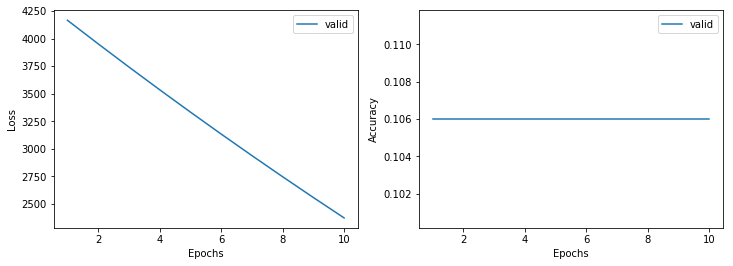

In [24]:
run_train(init_method = "normal", num_epochs=10)

In [25]:
run_test()

valid_accuracies:  0.1135


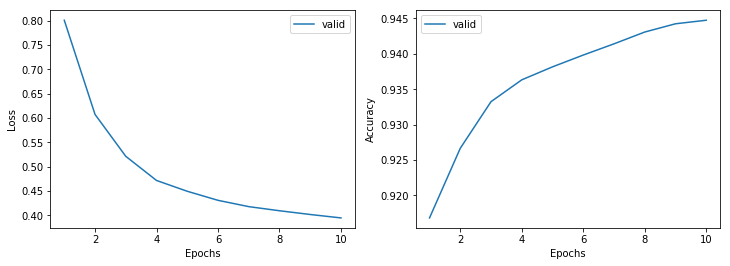

In [26]:
run_train(init_method = "Glorot", num_epochs=10)

In [27]:
run_test()

valid_accuracies:  0.9443


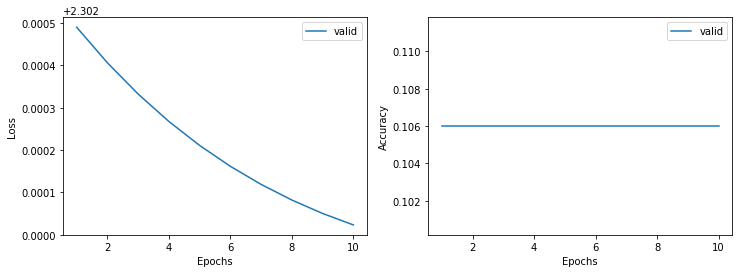

In [28]:
run_train(init_method = "zeros", num_epochs=10)

In [29]:
run_test()

valid_accuracies:  0.1135


## Second test:

In [30]:
learning_rate=1e-1
weight_decay=0.002

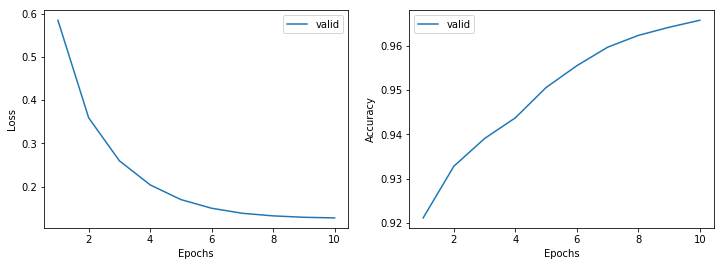

In [31]:
run_train(init_method = "Glorot", num_epochs=10)

In [32]:
run_test()

valid_accuracies:  0.9636


In [33]:
learning_rate=1e-2
weight_decay=0.0035

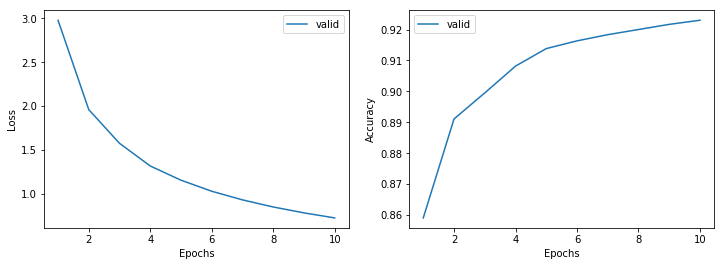

In [34]:
run_train(init_method = "Glorot", num_epochs=10)

In [35]:
run_test()

valid_accuracies:  0.9239


In [36]:
learning_rate=1e-1
weight_decay=0.0025

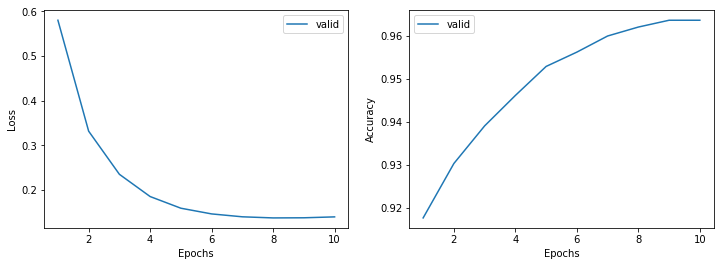

In [37]:
run_train(init_method = "Glorot", num_epochs=10)

In [38]:
run_test()

valid_accuracies:  0.9649


In [39]:
learning_rate=1e-1
weight_decay=0.0035

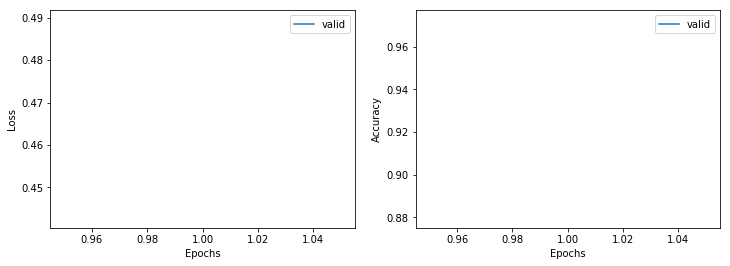

In [40]:
run_train(init_method = "Glorot", num_epochs=1)

In [41]:
run_test()

valid_accuracies:  0.9237
